In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Part 1: Gathering Data
===
There are many resources that provide datasets that have already been collected and formatted: [Kaggle](https://www.kaggle.com/datasets), [Google Public Data Explorer](https://www.google.com/publicdata/directory), and [The U.S. Government Database](https://www.data.gov/), just to name a few. However, we decided it would be interesting to explore the Billboard Hot 100 Songs Year End Charts for a variety of years. We chose this data because it would allow us to investigate our two main ideas: how popular music changes over time and can we classify popular music. 

Data can be difficult to find in a format that is standard and that provides everything you are looking for. In our case, the Billboard Charts provide the rank, title, and artists, but lack other charactistics of the music. To accomidate for this we utilized the Spotify API to wrangle a variety of other features as well as genre.

Part 1.1: Billboard Top 100 Web Scraping
===
To get information on popular songs for each year, we decided to use the Billboard Hot 100 Songs Year End Charts. *Why Billboard?* Initially we looked at the [Billboard website](https://www.billboard.com/charts/year-end/hot-100-songs), but the website only goes back to charts from 2005, and our goal was to span a much larger time frame than just 15 years. We eventually decided on using the data from Wikipedia, which includes lists of the Billboard Hot 100 songs for most years back to 1946. After 1960, there were no missing years, so we decided to work with the time frame of 1960-2020. 

In order to get the songs from Wikipedia, we scrape the information from the web page. For this we are using Requests and BeautifulSoup. [Requests](https://pypi.org/project/requests/) is a python library for making HTTP requests, which we use to get the HTML content of the webpages. [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) is a library which allows us to search within the HTML and parse it to get the data we are looking for.


In [2]:
# Imports for web scraping
import requests
from bs4 import BeautifulSoup

We are using pandas to store and manipulate our data. *Why pandas?* - good within python, stored in memory, multiple types. Each year is a separate page on Wikipedia, but we found that the format of the URL to follow the pattern "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of\_*[year]*". Iterating over every year in the period we chose, we use the requests library to get the HTML content of the page, then use Beautiful Soup to parse the string into an object. Using our browser developer tools to select the table element with the songs, we see that the table uses the class "wikitable". With this information, we can take advantage of Beautiful Soup's [`find()`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) function to get just that table. Pandas provides a function [`read_html()`](https://pandas.pydata.org/docs/reference/api/pandas.read_html.html) which allows us to turn the HTML table into a pandas DataFrame. With all of the songs from one year in a DataFrame, we can add the songs into a DataFrame containing all of the songs, with the attributes "Year", "Rank", "Song", and "Artist(s)".

In [7]:
top100 = pd.DataFrame()

# General form of URL
url = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_'
for year in range(1960, 2021):
    # Get HTML from URL and parse
    r = requests.get(url + str(year))
    html = r.content
    root = BeautifulSoup(r.content, "html.parser")

    # Search for a table with the class "wiki table" and read into dataframe
    r = root.find("table", "wikitable")
    pretty = r.prettify()
    df = pd.read_html(pretty)[0]

    # Rename columns and add a column for the year
    df.columns = ['Rank', 'Song', 'Artist(s)']
    df = df.assign(Year = year)

    # Add dataframe to top100
    top100 = top100.append(df)

display(top100.head())
top100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rank       6101 non-null   object
 1   Song       6101 non-null   object
 2   Artist(s)  6101 non-null   object
 3   Year       6101 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.3+ KB
None


After gathering all of the songs into one DataFrame, we display the first five rows of our data using [`DataFrame.head()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) and show some information about our DataFrame using [`DataFrame.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) so we can check that we have all of the data we expect. If we had 100 songs for each of the 61 years we looked at, we would have 6100 rows in the DataFrame. Instead, we have 6101. This means that we have one more row than we should. Additionally, the "Rank" column has the data type `object`, even though every element should be an integer. To find the problem, we print out the unique values in the "Rank" column. Exploring our data further, we found that both problems have the same source. One rank is listed as 'Tie', which causes there to be more than 100 rows for one year, 1969, as well as prevents the column from have type `int64`. Going to our orginal data source, we can confirm that this is a tie for the rank of 100 in 1969. In order to resolve the type problem, we reassign the rank for this row to 100, then cast the column to have type `int64`. 

Additionally, when we display the first 5 rows of our data, we can see that the song titles are surrounded by quotation marks, which could cause problems for our search later on, so we will remove them now.

In [15]:
# Reformat rank to be integers
top100.loc[top100['Rank'] == 'Tie', 'Rank'] = 100
top100 = top100.astype({'Rank': 'int64'})

# Remove quotations from song titles
top100["Song"] = top100["Song"].str.strip('"').str.strip()
top100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rank       6101 non-null   int64 
 1   Song       6101 non-null   object
 2   Artist(s)  6101 non-null   object
 3   Year       6101 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.3+ KB


Periodically, we will be saving our current DataFrame to a .csv file. We decided to do this because the nature of our data collection, making many HTTP requests, has a high risk of uncontrollableerrors, including server time-out, API rate-limiting, etc. This type of data collection can also be fairly slow. Saving the data to an external file allows us to access the data at a later time without rerunning the code, and also helps mitigate the risk of losing all of the previously collected information due to an unexpected error.

In [ ]:
# Export DataFrame
top100.to_csv('../data/RawYearlyTop100.csv', index=False)

Part 1.2: Spotify Track ID Collection
===

Next we want some more detailed information about each of the songs. The way we chose to get this information is using the Spotify API. In order to access the endpoints we want to use, we will use the [Spotipy](https://spotipy.readthedocs.io/en/2.18.0/) library, which provides a wrapper for the Spotify Web API. In order to get any information about the tracks from Spotify, we need the track ID. We will be getting this using the Search endpoint of the API, which allows us to input a search query, and will return a number of matching tracks.

Our options include the MusicBrainz Database. We decided to use Spotify instead because Spotify includes an endpoint to access an audio analysis for each song, while MusicBranz is more focused on the releases of the songs, rather than the sound of the song.

In [3]:
# Imports for Spotify searching
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [ ]:
# Read in data from CSV
top100 = pd.read_csv('../data/RawYearlyTop100.csv')

The names of songs and artists as they are listed in our DataFrame is not ideal for searching. Many tracks in Spotify don't actually list all of the artists, so we split the string in the "Artist(s)" column on words/characters like "featuring", "and", "&", and ",", keeping only the first artist, as this is usually the artist associated with the album the song is in, and thus, the artist associated with the song on Spotify. Additionally, characters like "'" appear in many song names, but can cause problems with the search query, so we remove them. Additionally, some songs have names with a "/", such as "We Will Rock You  /  We Are the Champions". Testing out this type of search, we got the most accurate results removing everything after the "/", so we do that here.

In [6]:
# Choosing the first artist
top100["Artist(s)"] = top100["Artist(s)"].str.split('featuring', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split('and', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split('&', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split(',', expand=True)[0]

# Cleaning up the songs
top100["Song"] = top100["Song"].str.split("/", expand=True)[0]
top100["Song"] = top100["Song"].str.replace("'", " ")

Now that the artist and song names are more appropriate for our search query, we add a column, "Query", which formats the query as nessecary for the Spotify API. Formatting the query, rather than just searching adding the song title and the artist name to the search, will give us only results where the song and artist match well. This is likely to give us more missing data, if a song name is slightly different in Spotify, but it prevents false matching of songs.

In [7]:
# Create query column 
top100["Query"] = "track:" + top100["Song"] + " artist:" + top100["Artist(s)"]
top100.head()

,Rank,Song,Artist(s),Year,Query
0,1,Theme from A Summer Place,Percy Faith,1960,track:Theme from A Summer Place artist:Percy F...
1,2,He ll Have to Go,Jim Reeves,1960,track:He ll Have to Go artist:Jim Reeves
2,3,Cathy s Clown,The Everly Brothers,1960,track:Cathy s Clown artist:The Everly Brothers
3,4,Running Bear,Johnny Preston,1960,track:Running Bear artist:Johnny Preston
4,5,Teen Angel,Mark Dinning,1960,track:Teen Angel artist:Mark Dinning


In order to access the Spotify API, you need create an application in the [Spotify Developer Dashboard](https://developer.spotify.com/dashboard/applications). This gives the Client ID and Client Secret needed for authentication in the HTTP requests. Our credientials are saved in a file `config.json` to avoid exposing the credientials to the internet. Here, we use these credientials to create a spotipy object. 

In [4]:
# Create python object from json file
with open('../config.json') as file:
    app_data = json.load(file)

# Authenticate with Spotipy
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In order to search for each track, we will be adding information to an existing object. This function gets the data from the track from Spotify, and adds it to a row object that we can add back to a DataFrame.

In [9]:
# Adds the desired data in track to the row object
def add_data_to_row(row, track):
    row['ID'] = track['id']
    row['Popularity'] = track['popularity']
    row['Release Date'] = track['album']['release_date']

    # Create a list of the artists
    artists = []
    for i, artist in enumerate(track['artists']):
        artists.append(artist['id'])
    row['Artist IDs'] = artists
    
    row['Album ID'] = track['album']['id']
    return row

In [ ]:
# Initialize new DataFrame
new_columns = ["Year", "Rank", "ID", "Song", "Artist(s)", "Artist IDs", "Album ID", "Release Date", "Popularity", "Query"]
results = pd.DataFrame(columns=new_columns)
no_results = pd.DataFrame(columns = ["Year", "Rank", "Song", "Artist(s)", "Query"])

# Iterate over every row in top100
for i, row in top100.iterrows():

    # Make search with specific query
    search_res = sp.search(q=row['Query'], limit=5)
    tracks = search_res['tracks']['items']

    # If there are no results:
    if len(tracks) == 0:
        # Create a new query and search again
        new_query = row["Artist(s)"] + row["Song"]
        search2_res = sp.search(q=new_query, limit=5)
        tracks2 = search2_res['tracks']['items']

        # If there are still no results, add to "no_results"
        if len(tracks2) == 0:
            no_results = no_results.append(row, ignore_index=True)
        
        else:
            # For every result, add to results DataFrame
            for idx, track in enumerate(tracks):
                row = add_data_to_row(row, track)
                results = results.append(row, ignore_index=True)
    else:
        # For every result, add to results DataFrame
        for idx, track in enumerate(tracks):
            row = add_data_to_row(row, track)
            results = results.append(row, ignore_index=True)

# Save results, and list of missing tracks to csv files
results.to_csv('../data/search-results/all.csv', index=False)
no_results.to_csv('../data/search-results/all_missing.csv', index=False)

Part 1.3: ID selection
===
The Spotify Search API used to get the ID information above provides the top 5 results for each track based on the popularity metric. In order to get the audio features, we must select a single one of the results for each song in the top 100 of each year. The song that is most likely to be the version listen in the Billboard Top 100 would be the oldest. The oldest is closest to the original release date.

The Pandas library allows us to convert our column of strings into datetime objects. This is extremely useful because it allows for a meaningful comparison between the values.

In [4]:
# Load data from Spotify search results
results = pd.read_csv('../data/search-results/all.csv')

# Format release date as datetime object (0000 is set as None as it is a missing value)
results.loc[results['Release Date'] == "0000",'Release Date'] = None
results['Release Date'] = pd.to_datetime(results['Release Date'])

In [42]:
# Create new dataframe of the oldest result for each song
selected = pd.DataFrame()

# Select the oldest result of each song
for q, song in results.groupby(['Query','Year']):
    oldest = song.iloc[0]
    for i, result in song.iterrows():
        if (result['Release Date']) < (oldest['Release Date']):
            oldest = result
    selected = selected.append(oldest, ignore_index=True)

# Results ((6101 songs - 31 missing from spotify search) = 6070 songs selected)
selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070 entries, 0 to 6069
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Album ID      6070 non-null   object        
 1   Artist IDs    6070 non-null   object        
 2   Artist(s)     6070 non-null   object        
 3   ID            6070 non-null   object        
 4   Popularity    6070 non-null   float64       
 5   Query         6070 non-null   object        
 6   Rank          6070 non-null   float64       
 7   Release Date  6070 non-null   datetime64[ns]
 8   Song          6070 non-null   object        
 9   Year          6070 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 474.3+ KB


In [ ]:
# Export results
selected.to_csv('../data/search-results/all_selected.csv', index=False)

In order to see the performance of this selection, we view the summary statistics for the differences between the release year and the year the song appeared on the Billboard Top 100.

In [44]:
# Result statistics
differences = (selected['Release Date'].dt.year - (selected['Year']))
differences.describe()

count    6070.000000
mean        2.126359
std         9.934072
min       -87.000000
25%        -1.000000
50%         0.000000
75%         0.000000
max        59.000000
dtype: float64

The mean of 2.13 supports our idea that the oldest result it likely clossest to that of the Billboard entry; The statistic means that, on average, the selected spotify listing of the track has a release date 2 years after the song appeared on the Billboard Top 100. There is however a standard deviation of 10 years; Although this may seem significant, other selection processes we tested performed similarly if not worse, including: selecting the song with the release date clossest to the year of the Billboard Top 100, selecting the song with the oldest release date (if after the Billboard year) or the song with the clossest to the Billboard year (if before the Billboard year), etc.

Overall, the selection process we used not only performed well in comparison to other methods, but also tried to select the most original version of the song.

Part 1.4: Get Audio Features
===

We chose to query Spotify because the API provides audio features that numerically describe music. There are two types of data, categorical and quantitative. For the purposes of viewing trends and later classifying the data, it is interesting and useful to have mixture of both types. Music is often divided into groups based on subjective factors; The Spotify audio features provide objective (based on spotifies definitions) features about the songs.

In [22]:
# Uses the same imports as spotify ID search

# Load credentials
with open('../config.json') as file:
    app_data = json.load(file)

# Authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In [23]:
# Load data for selected tracks
all_years = pd.read_csv('../data/search-results/all_selected.csv')

# Remove problematic row
delete_row = all_years[(all_years["Year"]==2005.0) & (all_years["Rank"] == 80)].index
all_years = all_years.drop(delete_row)

When performing the search below, we found that the ID Spotify provided for the rank 80 song from 2005 does not work when searching for audio features. As a result we remove this row because we do not have the features it is associated with (similar reasoning to the removal of missing data described previously).

The Spotify Audio Features API allows for a maximum of 100 song IDs to be provided on each search. In order to accomodate this, we group by rank which will be a maximum of 62 songs per query.

In [24]:
# Create dataframe with the added audio features
all_audio_features = pd.DataFrame()

for rank_val, rank in all_years.groupby('Rank'):

    # Get dataframe of audio features for this rank
    audio_features = pd.DataFrame (sp.audio_features(tracks=rank['ID']))

    # Combine new information with existing data
    rank_and_features = rank.merge(audio_features, left_on='ID', right_on='id', how='inner')
    rank_and_features = rank_and_features.drop(columns=['track_href','type','uri','analysis_url','id'])
    all_audio_features = all_audio_features.append(rank_and_features)

# Display characteristics of result
all_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6069 entries, 0 to 61
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Album ID          6069 non-null   object 
 1   Artist IDs        6069 non-null   object 
 2   Artist(s)         6069 non-null   object 
 3   ID                6069 non-null   object 
 4   Popularity        6069 non-null   float64
 5   Query             6069 non-null   object 
 6   Rank              6069 non-null   float64
 7   Release Date      6069 non-null   object 
 8   Song              6069 non-null   object 
 9   Year              6069 non-null   float64
 10  danceability      6069 non-null   float64
 11  energy            6069 non-null   float64
 12  key               6069 non-null   int64  
 13  loudness          6069 non-null   float64
 14  mode              6069 non-null   int64  
 15  speechiness       6069 non-null   float64
 16  acousticness      6069 non-null   float64
 1

As seen in the info above, the result of the audio features query contains 6069 songs (6070 from previous data - 1 removed for missing data), and there are no columns that contain null values.

In [ ]:
# Export results
all_audio_features.to_csv('../data/Billboard_Audio_Features.csv', index=False)

Part 1.5: Get Genre
===

Another feature we may want to look at is genre. However, the Spotify API has no way of directly obtaining genre of a particular track. Instead, we must obtain the genre through the Artist ID. Since we may have several artists on the same track, we will choose to take the primary artist, whose genres should just as, if not more, indicative of the genre of the track. We will take the list of genres returned and convert them into a string for further processing.

In [25]:
# Uses the same imports as spotify ID search

# Load credentials
with open('../config.json') as file:
    app_data = json.load(file)

# Authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In [27]:
# Load data with audio features
all_years = pd.read_csv('../data/Billboard_Audio_Features.csv')

# Convert strings of artist IDs into lists of artist IDs and select the first artist
all_years['Artist IDs'] = all_years['Artist IDs'].str.lstrip('[').str.rstrip(']')
all_years['Primary Artist ID'] = all_years['Artist IDs'].str.split(',', expand = True)[0].str.strip("'")

# Create column for genres
all_years['Genres'] = pd.Series(dtype=object)

# Create empty dataframe for results
all_with_genres = pd.DataFrame(columns=all_years.columns)

In [ ]:
# Iterate through rows and lookup the primary artist's genres
for i, row in all_years.iterrows():
    artist = sp.artist(row['Primary Artist ID'])
    row['Genres'] = ", ".join(artist["genres"])
    all_with_genres = all_with_genres.append(row, ignore_index= True)

In [ ]:
# Export data
all_with_genres.to_csv('../data/Billboard_Audio_Features.csv', index=False)

In [33]:
# Read in data and drop songs with no genre found
data = pd.read_csv('../data/Billboard_Audio_Features.csv')
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5746 entries, 0 to 5745
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Album ID           5746 non-null   object 
 1   Artist IDs         5746 non-null   object 
 2   Artist(s)          5746 non-null   object 
 3   ID                 5746 non-null   object 
 4   Popularity         5746 non-null   float64
 5   Query              5746 non-null   object 
 6   Rank               5746 non-null   float64
 7   Release Date       5746 non-null   object 
 8   Song               5746 non-null   object 
 9   Year               5746 non-null   float64
 10  danceability       5746 non-null   float64
 11  energy             5746 non-null   float64
 12  key                5746 non-null   int64  
 13  loudness           5746 non-null   float64
 14  mode               5746 non-null   int64  
 15  speechiness        5746 non-null   float64
 16  acousticness       5746 

In [36]:
# Output the counts of full genre strings
data['Genres'].value_counts()[:25]

dance pop, pop, post-teen pop                                                      104
dance pop, pop                                                                      61
contemporary country, country, country road                                         52
dance pop, pop, urban contemporary                                                  51
bubblegum pop                                                                       43
karaoke                                                                             40
barbadian pop, dance pop, pop, pop rap, post-teen pop, urban contemporary           32
soft rock                                                                           30
pop, post-teen pop                                                                  28
canadian hip hop, canadian pop, hip hop, pop rap, rap, toronto rap                  28
glam rock, mellow gold, piano rock, soft rock                                       27
beatlesque, british invasion, classic rock,

As seen in the output above, the issue with the genre data is that the string can contain many different genres. In order to perform exploratory data analysis on genre, we want to place most of the songs into singular, meaningful categories. That means that we must convert entries like "dance pop, pop, post-teen pop" into just "pop" and entries like "contemporary country, country, country road, modern country rock" into just "country". Our strategy was to use key phrases like "pop" and "rock" to place songs into categories. The issue is that many songs have overlapping genres such as "dance pop, pop, pop rap, r&b, rap". Thus, we prioritized categories according to their prevalence. For instance, since "disco" was rarer than "pop", a string with "disco, dance pop" would be placed in the "disco" category. Since rock and pop had equivalent prevalence, we would choose one or the other based on the number of occurences of the keyword. So "dance pop, teen pop, rock" would be classified as rock. Doing this, we condensed all of the genres into 8 categories: country, disco, edm, soul/r&b, hip hop/rap, alternative/indie, rock, and pop.

In [34]:
# Empty dataframe with same columns
new_data = pd.DataFrame(columns=data.columns)

# Iterate through rows and place songs into genre categories
for i, row in data.iterrows():
    # Set to NaN if no appropriate genre found
    genre = np.nan

    # Take genres string
    genres = row["Genres"]

    # If contains keyword, place in genre
    # For pop/rock, count occurences and place into genre with most
    if "country" in genres:
        genre = "country"
    elif "disco" in genres:
        genre = "disco"
    elif "edm" in genres or "electro" in genres:
        genre = "edm"
    elif "r&b" in genres or "soul" in genres:
        genre = "soul/r&b"
    elif "hip hop" in genres or "rap" in genres:
        genre = "hip hop/rap"
    elif "alternative" in genres or "indie" in genres:
        genre = "alternative/indie"
    elif "rock" in genres or "pop" in genres:
        rock = 0
        pop = 0
        for g in genres.split(','):
            if "rock" in g:
                rock += 1
            if "pop" in g:
                pop += 1
        if rock >= pop:
            genre = "rock"
        else:
            genre = "pop"
    # Set row to chosen genre and append
    row["Top Genre"] = genre
    new_data = new_data.append(row)
    
# Counts of each genre
new_data['Top Genre'].value_counts()

rock                 1290
pop                  1063
soul/r&b              957
hip hop/rap           771
country               603
disco                 426
edm                   159
alternative/indie     155
Name: Top Genre, dtype: int64

In [ ]:
# Export data
new_data.to_csv('../data/Billboard_Audio_Features.csv', index=False)

Now we have placed each song into a genre and can continue to exploratory data analysis.

Part 2: Explanatory Data Analysis
===

Part 2.1: Exploration of Features
===

In [9]:
# Imports
import seaborn as sn

In [3]:
# Load complete dataset
data = pd.read_csv('../data/Billboard_Audio_Features.csv')

# Drop irrelevant columns for 
data = data.drop(columns=['Album ID', 'Artist IDs', 'Query', 'Song', 'Artist(s)'])

# Drop songs with no genre
data = data.dropna()

# Display
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5424 entries, 0 to 5745
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5424 non-null   object 
 1   Popularity         5424 non-null   float64
 2   Rank               5424 non-null   float64
 3   Release Date       5424 non-null   object 
 4   Year               5424 non-null   float64
 5   danceability       5424 non-null   float64
 6   energy             5424 non-null   float64
 7   key                5424 non-null   int64  
 8   loudness           5424 non-null   float64
 9   mode               5424 non-null   int64  
 10  speechiness        5424 non-null   float64
 11  acousticness       5424 non-null   float64
 12  instrumentalness   5424 non-null   float64
 13  liveness           5424 non-null   float64
 14  valence            5424 non-null   float64
 15  tempo              5424 non-null   float64
 16  duration_ms        5424 

,ID,Popularity,Rank,Release Date,Year,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Primary Artist ID,Genres,Top Genre
0,5HQ6AUDMbMuwktvcNPuV1y,36.0,1.0,1991-01-01,1991.0,0.521,0.349,1,-13.452,1,...,0.06480,0.000013,0.0550,0.273,131.189,398027,4,3Z02hBLubJxuFJfhacLSDc,"album rock, canadian pop, canadian singer-song...",rock
1,0mUyMawtxj1CJ76kn9gIZK,75.0,1.0,2005-02-22,2006.0,0.599,0.785,3,-4.013,1,...,0.44800,0.003360,0.1510,0.520,140.046,233640,4,7xTcuBOIAAIGDOSvwYFPzk,"canadian pop, neo mellow, pop rock",pop
2,2goLsvvODILDzeeiT4dAoR,76.0,1.0,1998-01-01,1999.0,0.652,0.917,6,-6.720,1,...,0.00820,0.000000,0.0509,0.459,132.975,239027,4,72OaDtakiy6yFqkt4TsiFt,"dance pop, hollywood, new wave pop, pop, pop rock",pop
3,0kPeymTUiaidv48eRrMISu,64.0,1.0,2007-01-01,1981.0,0.659,0.541,5,-7.919,1,...,0.01740,0.000000,0.1980,0.560,116.685,224693,4,5PN2aHIvLEM98XIorsPMhE,"new wave pop, soft rock",rock
4,0VjIjW4GlUZAMYd2vXMi3b,94.0,1.0,2020-03-20,2020.0,0.514,0.730,1,-5.934,1,...,0.00146,0.000095,0.0897,0.334,171.005,200040,4,1Xyo4u8uXC1ZmMpatF05PJ,"canadian contemporary r&b, canadian pop, pop",soul/r&b


Feature Ranges:
- acousticness 0.0 - 1.0
- danceability 0.0 - 1.0
- energy 0.0 - 1.0
- instrumentalness 0.0 - 1.0
- liveness 0.0 - 1.0
- speechiness 0.0 - 1.0
-  valence 0.0 - 1.0
- popularity 0 - 100
- time_signature categorical
- tempo bpm
- loadness -60 - 0
- mode major vs minor
- key categorical
- duration_ms positive integer

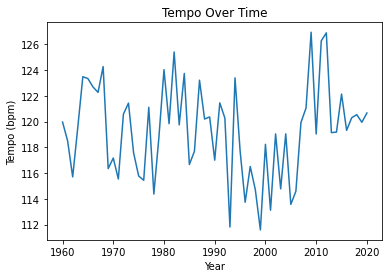

In [4]:
# Create a dataframe of the average of each feature per year
avgs = data.groupby("Year").mean().reset_index()

# Graph the relationship of tempo over time
ax = avgs.plot(x="Year", y="tempo")

# Labels
ax.set_ylabel('Tempo (bpm)')
ax.set_title('Tempo Over Time')
ax.get_legend().remove()

# Display
display()

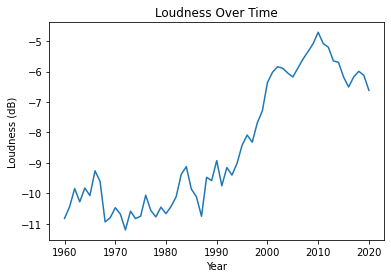

In [9]:
# Graph the relationship of loudness over time
ax = avgs.plot(x="Year", y="loudness")

# Labels
ax.set_ylabel('Loudness (dB)')
ax.set_title('Loudness Over Time')
ax.get_legend().remove()

# Display
display()

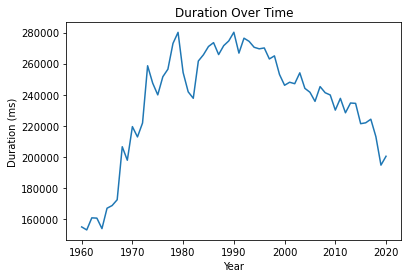

In [13]:
# Graph the relationship of duration over time
ax = avgs.plot(x="Year", y="duration_ms")

# Labels
ax.set_ylabel('Duration (ms)')
ax.set_title('Duration Over Time')
ax.get_legend().remove()

# Display
display()

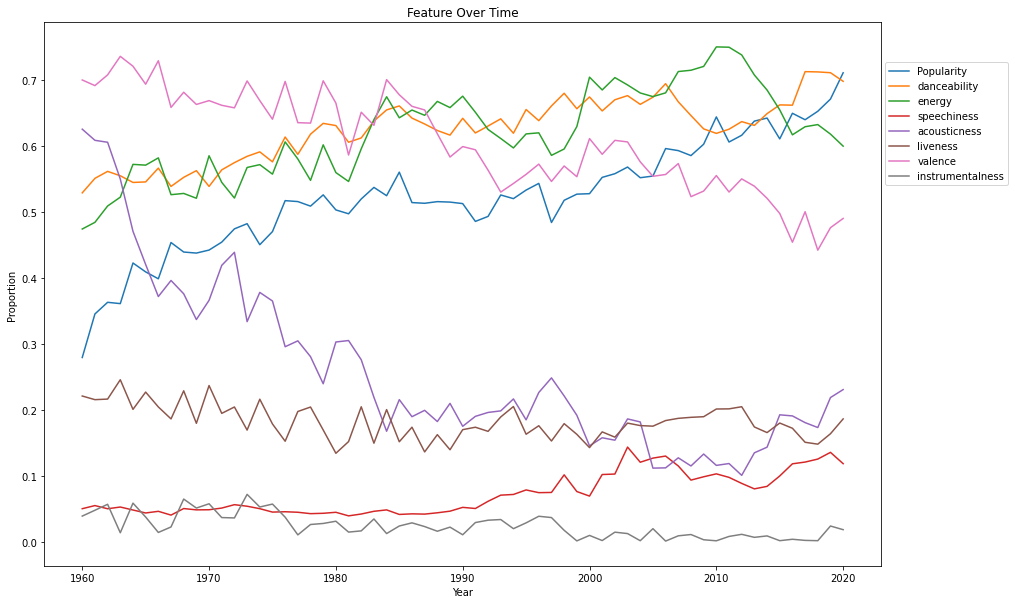

In [5]:
# Rescale average popularity to match other features
avgs['Popularity'] = avgs['Popularity'] / 100

# Array of features with 0.0 to 1.0 scale
features = ['danceability','energy','speechiness','acousticness','liveness','valence', 'instrumentalness']

# Create initial plot of popularity over time
ax = avgs.plot(x="Year", y='Popularity', figsize=(15,10))

# Add plots of other features to the plot
for feature in features:
    avgs.plot(x="Year", y=feature, ax=ax)

# Label and display
ax.set_ylabel('Proportion')
ax.set_title('Feature Over Time')
ax.legend(loc=(1.005,0.7))
display()

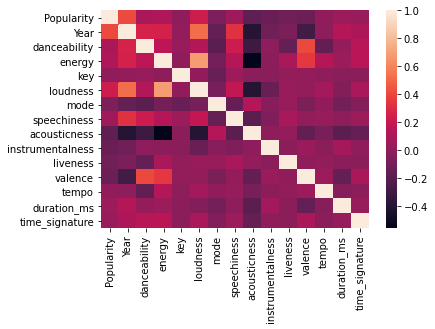

In [48]:
# Create 2D array of correlations and plot
corrs = data.drop(['Rank'], axis=1).corr()
sn.heatmap(corrs)

# Label and display
plt.title('Correlation of Features')
plt.show()

Part 2.2: Exploration of Genre
===

In [4]:
# Create dataframe for genre percent by year
genre_percent = pd.DataFrame()

# Get percentage of year that is each genre type
for y, rows in data.groupby('Year'):
    total = len(rows)
    # Create and populate row to be added
    new_row = {}
    new_row['Year'] = y
    for g, count in rows['Top Genre'].value_counts().iteritems():
        new_row[g] = count/total
    # Add row
    genre_percent = genre_percent.append(new_row, ignore_index=True)

# Replace empty genre percentages with 0%
genre_percent = genre_percent.replace(np.nan, 0)

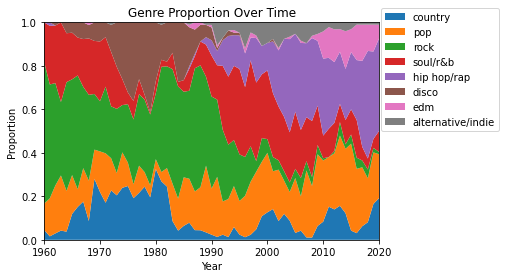

In [5]:
# Reformat genre_percent dataframe for plot
genre_columns = genre_percent.drop('Year', axis=1).transpose().to_numpy()

# Create plot showing genre division over time
plt.stackplot(genre_percent['Year'],genre_columns)

# Label and display
plt.legend(genre_percent.drop('Year', axis=1).columns,loc=(1.005,0.5))
plt.xlim(1960,2020)
plt.ylim(0,1)
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Genre Proportion Over Time')
display()

In [29]:
# Create a dataframe of the average of each feature per genre
data.groupby('Top Genre').mean()[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
Top Genre,,,,,,,,,,,,
alternative/indie,0.542510,0.741785,4.806452,-6.095174,0.774194,0.043202,0.104419,0.022460,0.173363,0.528571,124.011626,243029.658065
country,0.576854,0.596515,5.316750,-9.108643,0.854063,0.043375,0.300146,0.012771,0.176951,0.609237,121.208128,225771.673300
disco,0.650005,0.586485,5.401408,-10.640622,0.629108,0.049814,0.293952,0.042251,0.186396,0.690267,118.331310,270524.835681
edm,0.671069,0.698082,5.364780,-5.749308,0.591195,0.100986,0.142479,0.027229,0.160148,0.526826,119.645428,220808.044025
hip hop/rap,0.734201,0.679448,5.654994,-6.289724,0.573281,0.171719,0.116275,0.013333,0.201890,0.558777,118.736595,239301.067445
pop,0.624875,0.646237,5.233302,-7.744183,0.688617,0.057938,0.261869,0.024659,0.175172,0.602963,118.965252,227133.331138
rock,0.560775,0.612283,5.083721,-9.424492,0.788372,0.045340,0.295345,0.028425,0.184704,0.607356,122.029451,231397.483721
soul/r&b,0.664520,0.573771,5.560084,-8.615846,0.594566,0.079703,0.273966,0.022854,0.172080,0.618500,114.954679,244294.026123


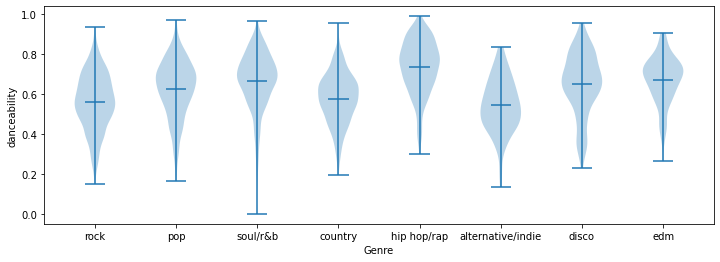

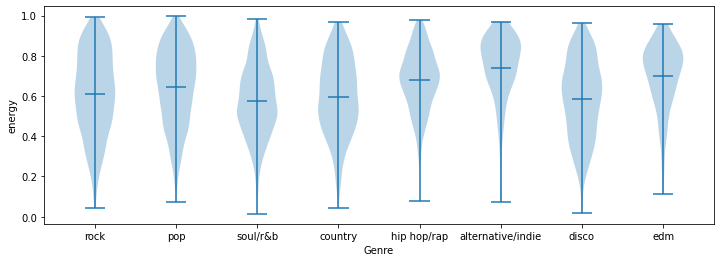

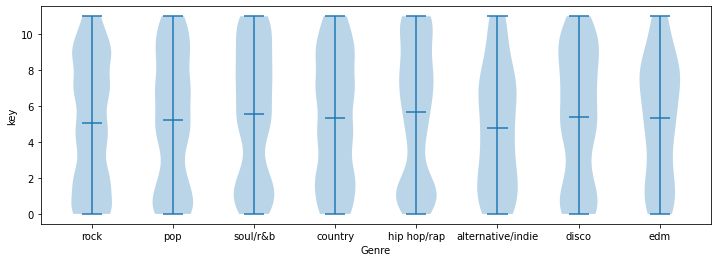

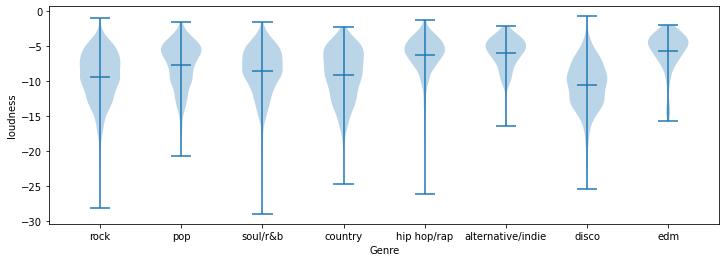

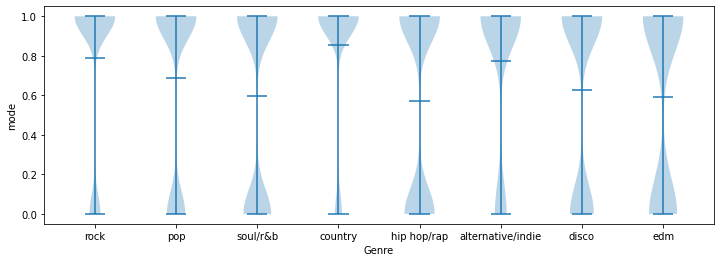

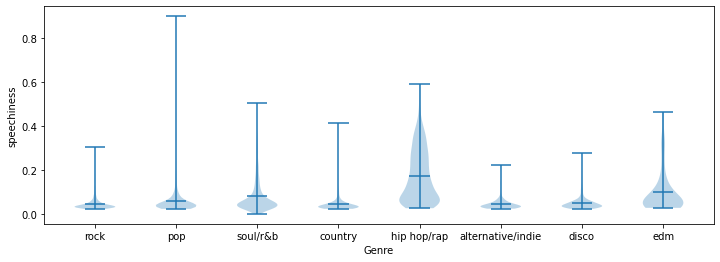

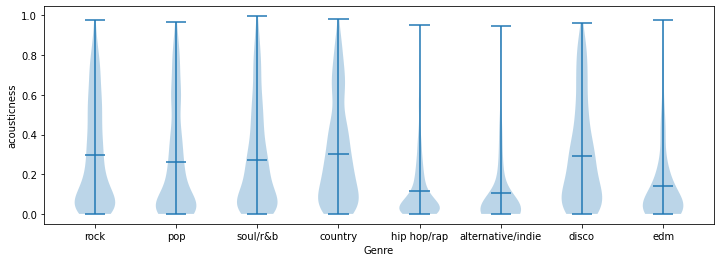

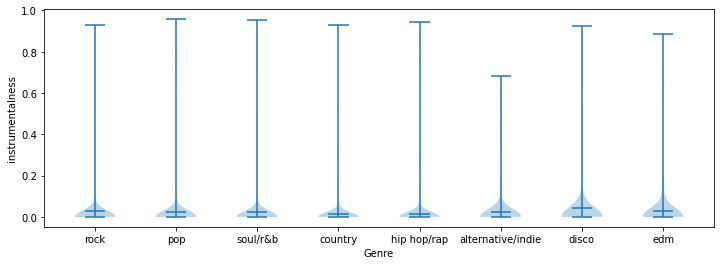

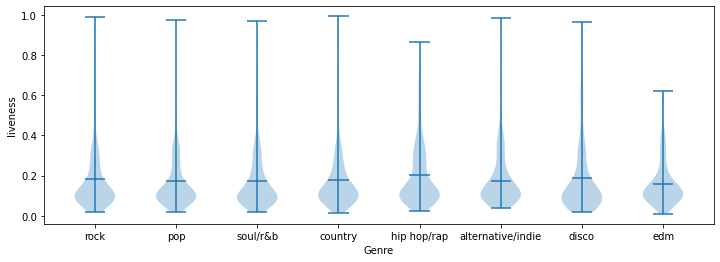

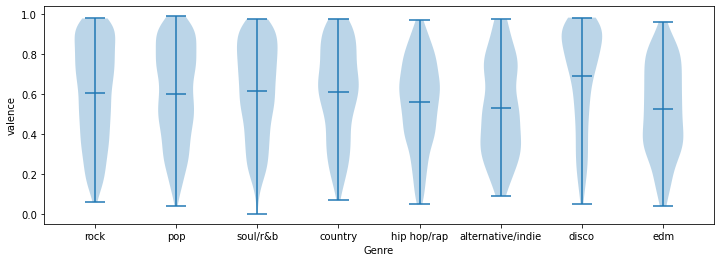

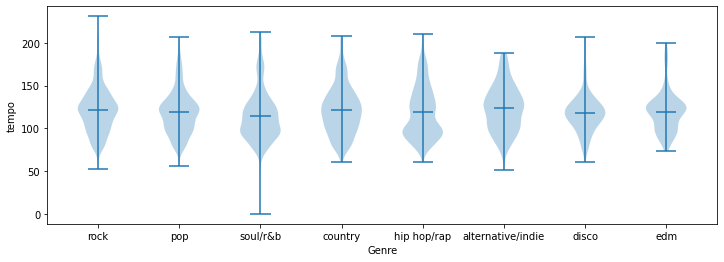

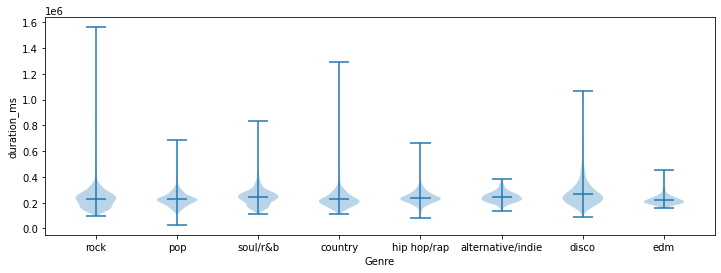

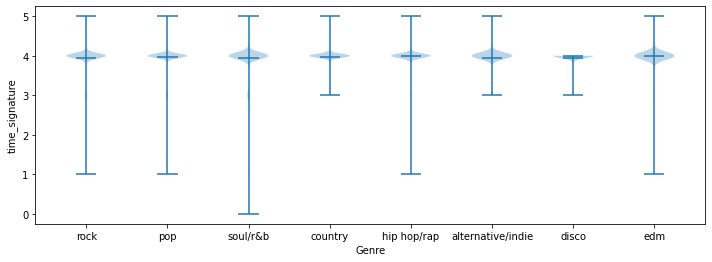

In [12]:
# Get list of genres
genres = data['Top Genre'].unique()

# Create violin plot of each feature for each genre
for feature in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']:
    # Create array of all values of the feature for each genre
    feature_by_genre = [data.loc[data["Top Genre"] == genre][feature].values for genre in genres]

    # Create plot
    plt.figure(figsize=(12, 4))
    plt.violinplot(feature_by_genre, range(0, len(genres)), showmeans=True)

    # Label
    plt.xticks(range(0, len(genres)), labels=genres)
    plt.xlabel("Genre")
    plt.ylabel(feature)

Part 3: Hypothesis Testing
===

In [ ]:
from sklearn import linear_model
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Part 4: Modeling / ML
===

Part 5: Conclusion
===